# **Decoding Airbnb Pricing in Boston: How hosts, properties, and locations shape costs for users.**

## *In what ways do host attributes, property type and location contribute to the pricing structure of Airbnb listings in Boston?*

# **Introduction**

### Brief

With rising living standards, travel has become more accessible, and platforms like Airbnb play a key role in short-term rentals. Boston is known for its strong tourism industry and high cost of living, making it an interesting place to study Airbnb prices **(Wang & Nicolau, 2017)**. As we know, Boston is known for its vibrant tourism and high cost of living. Hence, understanding housing prices on Airbnb is crucial for both landlords and travellers. Also, pricing structure is influenced by multiple factors such as the size of the property, number of bedrooms and bathrooms, location, and host reputation **(Gibbs et al., 2018; Chica-Olmo et al., 2020; Toader & Negrușa, 2021)**. For example, properties closer to famous attractions or in wealthier neighborhoods tend to be more expensive, while places in low-income areas are often cheaper **(Zhang & Liu, 2019)**. Also, some literatures show that neighborhood conditions, such as poverty rates and median household income, play an important role in Airbnb pricing **(Zhang et al., 2021)**. In this research, I am going to study how host attributes, property characteristics, and location contribute to the pricing structure of Airbnb rentals in Boston.

At the same time, host characteristics affects prices as well. Superhosts with multiple listings often charge more because they have experience and good reviews **(Teubner et al., 2017)**. Also, some literatures suggests that Airbnb hosts adjust their prices based on competitions, which similar to how businesses set prices in traditional markets **(Piao, 2023)**. For example, research on Airbnb in San Francisco found that pricing can even be influenced by the host’s background, which raises questions about potential biases in the platform **(Kakar et al., 2016)**. There is also growing interests in whether Airbnb hosts use pricing strategies, which could impact price differences between listings **(Pittala et al., 2024)**.

In this research, I will explore factors shaping Airbnb prices in Boston, using Airbnb Listings data (scraped on September 7, 2016) as the primary dataset **(scraped on September 7, 2016, Kaggle)**. Additionally, 2015-2019 Neighborhood Tables from "Analyze Boston" provide socioeconomic indicators like poverty rates, population density, and median income to assess location-based pricing influences **(ANALYZE BOSTON, 2021)**. By combining these datasets, I apply both traditional regression techniques and machine learning models (e.g., regression trees and random forests) to capture complex, nonlinear relationships that a simple model might miss. This research aims to provide data-driven insights into Airbnb pricing structure, and it will help both hosts to optimize pricing strategies and travelers to make informed decisions.

# **Variables:**

#### Outcome Variable


The outcome variable is price which specifically represents the **listing price per night** for an Airbnb property in Boston. This is the outcome variable in my research.

#### Independent Variable

1. **host listings count (host_listings_count)**:
   This indicates whether a host manages multiple properties. Higher values may suggest professional hosts who might price listings differently than individual hosts.


2. **Time start hosting (host_since)**: It represents the experience of the host. More experienced hosts might have better reputations, leading to higher demand and prices.

3. **Check superhost status (host_is_superhost)**: A categorical variable (which only takes value True and False). Superhosts often have better reviews and reliability, allowing them to charge premium prices.

4. **property type (property_type)**: It represents different types (e.g., apartments, houses, condos) of property which have varying levels of demand and pricing structures.

5. **bedrooms**: It is one of the amentities. More bedrooms generally lead to higher prices, as larger accommodations cater to more guests.

6. **bathrooms**: It is one of the amentities. Similar to bedrooms, more bathrooms typically increase the rental price, as they improve guest convenience.

7. **Region**: It represents all districts in Boston. Also, different neighborhoods have distinct demand levels based on proximity to key attractions, safety, and public transport access. 

8. **Per Capita Income**: It shows the average income level for each person in every district of Boston. Listings in wealthier neighborhoods may be priced higher due to the higher cost of living and increased demand from wealthier tourists.

9. **Median Household Income**: It represents the middle income level among all districts in Boston. A proxy for neighborhood affluence, which might correlate with the cost of rentals in that area.

10. **Poverty Rate**: Literally, it is just the poverty rate over all regions in Boston. Also, higher poverty rates may suggest lower demand and therefore lower prices, while lower poverty rates may indicate areas with higher Airbnb pricing.

# **Importing Tools**

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import osmnx as ox
from statsmodels.iolib.summary2 import summary_col

# **Reading Files**

### Reading listings.csv

In [2]:
listings = pd.read_csv('listings.csv')

### Reading supplementary file

In [3]:
file_path = "2015-2019_neighborhood_tables_2021.12.21.xlsm"
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name='Poverty Rates') # Sheet name can be any name in the file, I randomly put one sheet here to make code run.

# **Data Cleaning**

### Cleaning the listing data

Here, I cleaned the listings data by removing all dollar signs and turning them all into **float**. Also, I changed the date into the formal 
date demonstration. To make the data look good, I removed all commas in the string.

In [4]:
def clean_listings_data(df):
    numeric_columns = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = df[col].replace(r'[\\$,]', '', regex=True).astype(float, errors='ignore')
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df.dropna(subset=['price', 'minimum_nights'], inplace=True)
    df['amenities_count'] = df['amenities'].str.split(',').apply(len)  # Add amenities count column
    return df

In [5]:
listings_cleaned = clean_listings_data(listings)

### Cleaning the supplementary data

#### Per Capita Income

Here, I first read the file on the page of "Per Capita Income", then I extracted other columns except Per Capita Income. Also, I removed all dollar signs in the "Per Capita Income" and turn them into float. Moreover, I removed extra spaces from "Region" names to ensure filtering works. Lastly, I removed the rows of "Masschusetts".

In [6]:
df_income = pd.read_excel(xls, sheet_name="Per Capita Income")
df_income = df_income.iloc[3:, [0, 3]]  
df_income.columns = ["Region", "Per Capita Income"]

df_income["Region"] = df_income["Region"].str.strip()

df_income["Per Capita Income"] = df_income["Per Capita Income"].astype(str).str.replace(r'[\$,]', '', regex=True)
df_income["Per Capita Income"] = pd.to_numeric(df_income["Per Capita Income"], errors="coerce")

df_income = df_income[df_income["Region"] != "Massachusetts"]

#### Median Household Income

Here, I first read the file on the page of "Household Income", then I extracted other columns except "Median Household Income". Also, I removed all dollar signs in the "Median Household Income" and turn them into float. Moreover, I removed extra spaces from "Region" names to ensure filtering works. Lastly, I removed the rows of "Masschusetts".

In [7]:
df_household_income = pd.read_excel(xls, sheet_name="Household Income")
df_household_income = df_household_income.iloc[3:, [0, 1]] 
df_household_income.columns = ["Region", "Median Household Income"]

df_household_income["Region"] = df_household_income["Region"].str.strip()

x = df_household_income["Median Household Income"].astype(str).str.replace(r'[\$,]', '', regex=True)

y = pd.to_numeric(df_household_income["Median Household Income"], errors="coerce")

df_household_income["Median Household Income"] = x

df_household_income["Median Household Income"] = y

df_household_income = df_household_income[df_household_income["Region"] != "Massachusetts"]

#### Poverty Rate

Here, I first read the file on the page of "Poverty Rate", then I extracted other columns except "Poverty Rate". Also, I removed all percentage signs in the column of "Poverty Rate" and turn them into float. Moreover, I removed extra spaces from "Region" names to ensure filtering works. Lastly, I removed the rows of "Masschusetts".

In [8]:
df_poverty = pd.read_excel(xls, sheet_name="Poverty Rates")
df_poverty = df_poverty.iloc[3:, [0, 3]]
df_poverty.columns = ["Region", "Poverty Rate"]

df_poverty["Region"] = df_poverty["Region"].str.strip()

df_poverty["Poverty Rate"] = pd.to_numeric(df_poverty["Poverty Rate"], errors="coerce")

df_poverty = df_poverty[df_poverty["Region"] != "Massachusetts"]

# Summary Statistics

**Note**: "Count" represents total number of non-missing values in the column. "Unique" represents number of distinct values in the column.
"Top" represents the most frequently occurring value in the column. "Freq" represents the number of times the most frequent value appears.
"Mean" represents average. "Min" is minimum. "Max" is maximum. "25%", "75%", "50%" represents different quantiles. "Std" stands for standard deviation.

In [9]:
# Select relevant columns
selected_columns = [
    "price", "host_listings_count", "host_since", "host_is_superhost",
    "property_type", "bedrooms", "bathrooms", "neighbourhood_cleansed"
]

# Copy selected columns from listings dataset
listings_df = listings[selected_columns].copy()

# Convert price column to numeric and remove dollar sign
listings_df["price"] = listings_df["price"].astype(str).str.replace(r'[\$,]', '', regex=True)
listings_df["price"] = pd.to_numeric(listings_df["price"], errors="coerce")

# Convert host_since to datetime
listings_df["host_since"] = pd.to_datetime(listings_df["host_since"], errors="coerce")

# Rename neighbourhood column for merging
listings_df = listings_df.rename(columns={"neighbourhood_cleansed": "Region"})

# Merge economic data with Airbnb listings
merged_df = listings_df.merge(df_income, on="Region", how="left")
merged_df = merged_df.merge(df_household_income, on="Region", how="left")
merged_df = merged_df.merge(df_poverty, on="Region", how="left")

# Generate summary statistics without NA for numeric and categorical data
summary_numeric = merged_df.describe().dropna()
summary_categorical = merged_df.describe(include=["object", "bool"]).dropna()

# Calculate standard deviation for numeric variables
std_numeric = merged_df.std(numeric_only=True)

# Add standard deviation as a new row in the numeric summary statistics
summary_numeric.loc["std"] = std_numeric

# Save summary statistics to CSV
summary_numeric.to_csv("summary_numeric_with_std.csv", index=True)
summary_categorical.to_csv("summary_categorical.csv", index=True)

In [10]:
print("Summary Statistics (Numeric Data):")
print(summary_numeric.T)

Summary Statistics (Numeric Data):
                          count                           mean  \
price                    3585.0                     173.925802   
host_listings_count      3585.0                      58.902371   
host_since                 3585  2014-03-27 07:57:35.397489664   
bedrooms                 3575.0                       1.255944   
bathrooms                3571.0                       1.221647   
Per Capita Income        3476.0                    59856.77295   
Median Household Income  3476.0                   82156.230121   
Poverty Rate             3476.0                       0.192386   

                                         min                  25%  \
price                                   10.0                 85.0   
host_listings_count                      0.0                  1.0   
host_since               2008-11-11 00:00:00  2013-04-26 00:00:00   
bedrooms                                 0.0                  1.0   
bathrooms                

***Interpretations in terms of research question:*** 

The std of price is very large means properties range from budget to luxury. Price differences indicate that property characteristics and neighborhood factors strongly influence Airbnb pricing. Moreover, the mean and std of host_listing_count suggests that some hosts manage multiple listings while most have only one. For the host_since, it is just the indication of the starting date. Also, if experienced hosts or Superhosts charge higher prices, it suggests that guest trust and host reliability impact Airbnb pricing. Property size is a strong determinant of Airbnb pricing. Apartments dominate the market, but houses and larger properties explain price variation. This comes from the distribution of "bedrooms" and "bathrooms", we can compare them through different quantiles of the distribution. 25% means small apartment, 50% means it has 1-2 bedrooms or bathrooms and 75% means it has 2+ bedrooms or bathrooms. Also, the variation of them is supper small. With regard to the poverty rate and two income variables. "Per Capita Income" and "Median Household Income" has very large variation but "Poverty Rate" does not. So I conclude that if high-income areas charge more, it shows that Airbnb pricing aligns with general cost-of-living trends. Neighborhood wealth influences demand and listing pricing.

In [11]:
print("\nSummary Statistics (Categorical Data):")
print(summary_categorical)


Summary Statistics (Categorical Data):
       host_is_superhost property_type         Region
count               3585          3582           3585
unique                 2            13             25
top                    f     Apartment  Jamaica Plain
freq                3178          2612            343


**Interpretations in terms of research question:**
1. For the host_is_superhost, from the data above, especially "unique", it indicates that most listings are not superhosts which is that guest reviews and reputation may not always be the biggest pricing factor. If superhosts charge higher prices, it suggests that guests are willing to pay for the trusted hosts.
2. There are 13 different types of properties in Boston and aparment dominates the market. Regarding to my research question, I think if houses are priced significantly higher, it supports the idea that property type strongly affects Airbnb pricing.
3. For the region, "Jamaica Plain" has the most Airbnb listings, suggesting it is a popular area for Airbnb rentals. Regarding to my research question, if "Jamaica Plain" has lower prices, it might indicate high competition or lower demand. If some high-end neighborhoods charge more, it confirms that location is an important factor that affects Airbnb pricing.

# Visualizations

### Histogram

The line of code below, I created a new column of **"log_price"** to reduce the skewness of the data.

In [12]:
listings['log_price'] = np.log1p(listings['price'])

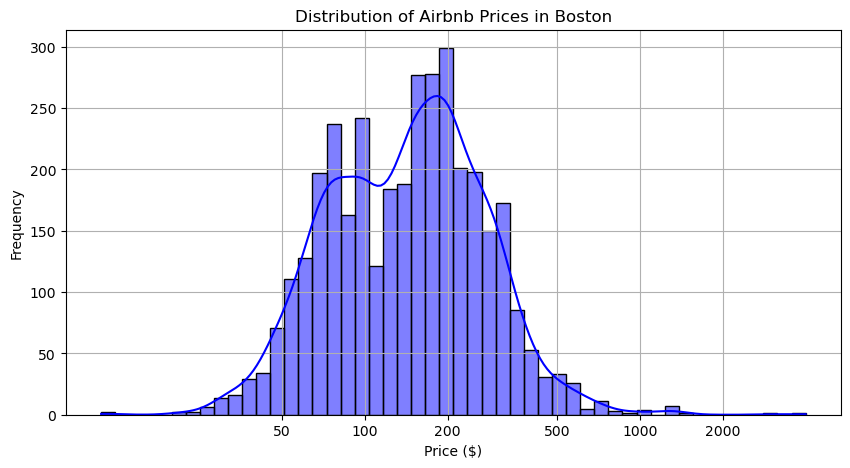

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(listings['log_price'], bins=50, kde=True, color='blue')
plt.xticks(ticks=np.log([50, 100, 200, 500, 1000, 2000]), labels=[50, 100, 200, 500, 1000, 2000])
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Airbnb Prices in Boston')
plt.grid(True)
plt.show()

#### Interpretations:


Here, this histogram shows the distribution of log-transformed Airbnb prices in Boston. Since the x-axis is in log scale, prices are compressed, but they still represent real values (e.g., log(100) ≈ 2, log(1000) ≈ 3). The peak of the histogram suggests that most listings fall within a common price range of approximately 100 to 300 US dollars per night. The rightward long tail indicates the presence of luxury listings, which are significantly more expensive but much less frequent. This distribution is right-skewed, meaning most Airbnb listings are in the lower-to-mid price range, and also only a few have exceptionally high prices. The non-uniformity of prices suggests that multiple factors (property type, location, host status) influence pricing, making it essential to explore how these variables contribute to price variations.



### Boxplot

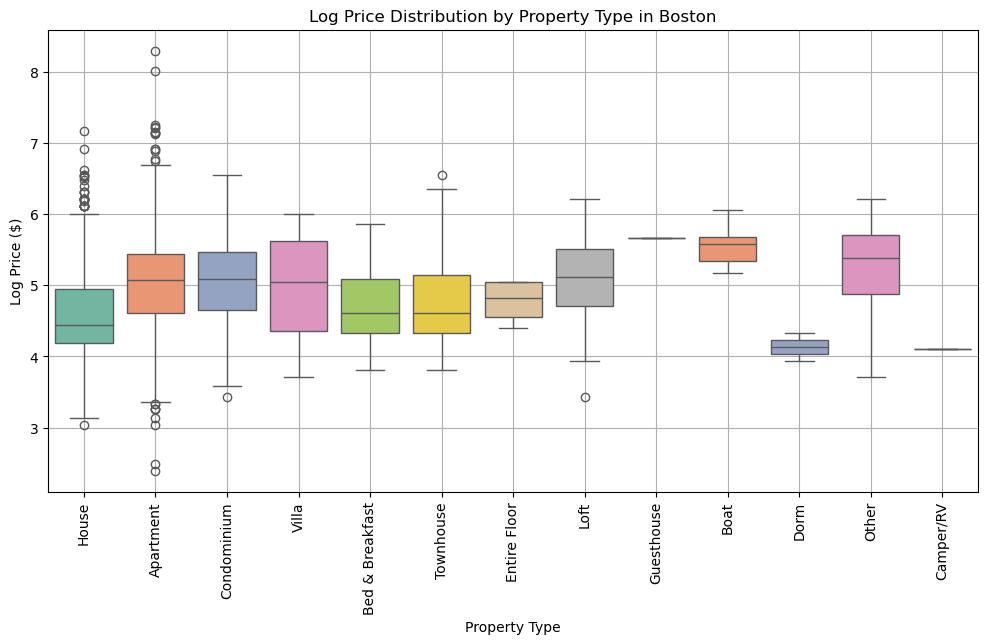

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='property_type', y='log_price', data=listings, hue='property_type', 
            legend=False, palette='Set2')
plt.xticks(rotation=90)
plt.xlabel('Property Type')
plt.ylabel('Log Price ($)')
plt.title('Log Price Distribution by Property Type in Boston')
plt.grid(True)
plt.show()

#### Interpretation:


Here, these boxplots illustrate the distribution of log-transformed Airbnb prices across different property types in Boston. Dorms and campers dominate the market with a lower median price and a relatively narrow interquartile range, indicating less price variability among listings. In contrast, villas and boats tend to have higher median prices or a wider IQR which are unique stays, reflecting greater diversity in property size and quality. Also, it suggests the presence of luxury listings that cater to high-end travelers. The width of each box represents the interquartile range, meaning a wider box signifies greater price dispersion within that property type. Regarding my research question, this confirms that property type is a major factor in Airbnb pricing, and the observed price segmentation suggests distinct market preferences, where budget travelers opt for affordable apartments while premium guests choose high-end, unique accommodations.


### Line Plot

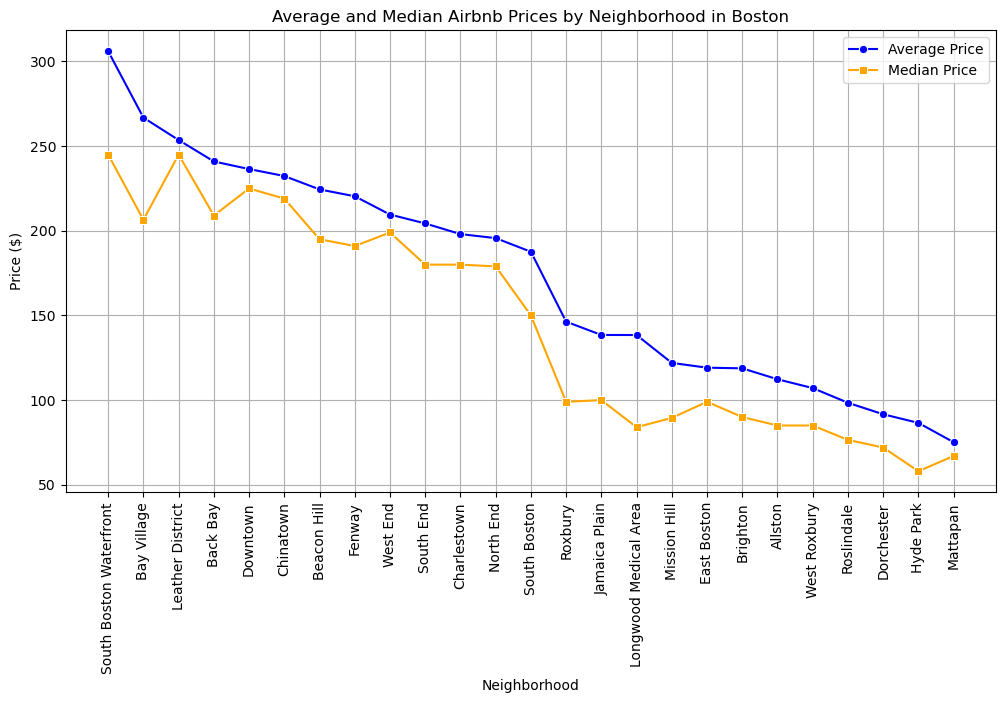

In [15]:
x = listings.groupby('neighbourhood_cleansed')['price'].agg(['mean', 'median']).sort_values(by='mean', ascending=False)
neighborhood_stats = x
plt.figure(figsize=(12, 6))
sns.lineplot(x=neighborhood_stats.index, y=neighborhood_stats['mean'], marker='o', 
             color='blue', label='Average Price')
sns.lineplot(x=neighborhood_stats.index, y=neighborhood_stats['median'], marker='s', 
             color='orange', label='Median Price')
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Price ($)')
plt.title('Average and Median Airbnb Prices by Neighborhood in Boston')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretations:

Here, this diagram shows the relationship between different kinds of neighborhood and price by showing uo two lines which are average price and median price. It shows a large variation in prices across neighborhoods and the average price is higher than the median price in all areas, it suggested that the presence of luxury listings or extreme outliers driving up the mean price. Regarding to my research question, this diagram confirms that location significantly impacts Airbnb pricing. Also, it highlights the effect of luxury listings on the average price because the difference between average and median prices suggests that some neighborhoods have high-end properties that push the average prices up.

### Scatter plot

##### Price vs. Number of Listings Managed by Host

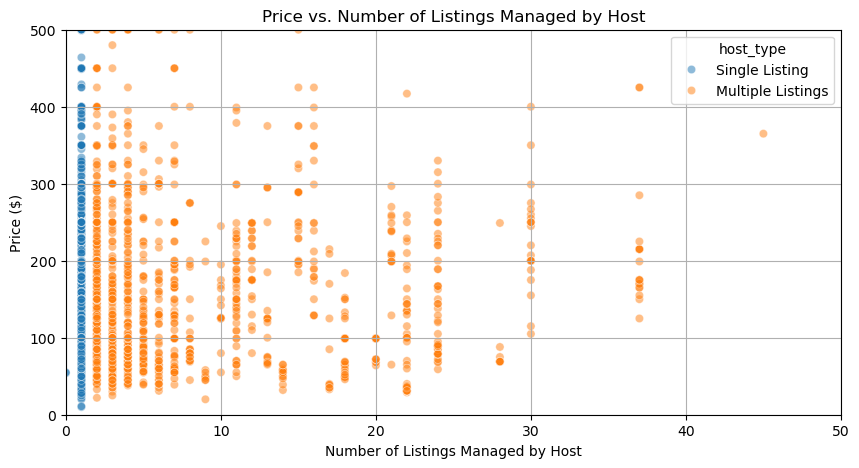

In [16]:
listings['host_listings_count'] = listings['host_listings_count'].fillna(1)
listings['host_type'] = listings['host_listings_count'].apply(lambda x: 'Multiple Listings' 
                                                              if x > 1 else 'Single Listing')

plt.figure(figsize=(10, 5))
sns.scatterplot(x=listings['host_listings_count'], y=listings['price'], hue=listings['host_type'], alpha=0.5)
plt.xlim(0, 50)
plt.ylim(0, 500)
plt.xlabel('Number of Listings Managed by Host')
plt.ylabel('Price ($)')
plt.title('Price vs. Number of Listings Managed by Host')
plt.grid(True)
plt.show()

#### Interpretations:

Here, this plot shows the relationship between price and number of listings managed by host. Also, it shows the majority of points are concentrated at lower host listing counts which suggests most Airbnb hosts in Boston are individual property owners rather than large-scale operators. Meanwhile, there are high-priced listings across all host types, meaning factors like location and property type matter more than host listing count. Regarding to my research question, it indicates competition among multi-listing hosts may keep prices stable and confirms that the number of listings managed by a host does not strongly impact pricing.

##### Price vs. Per Capita Income

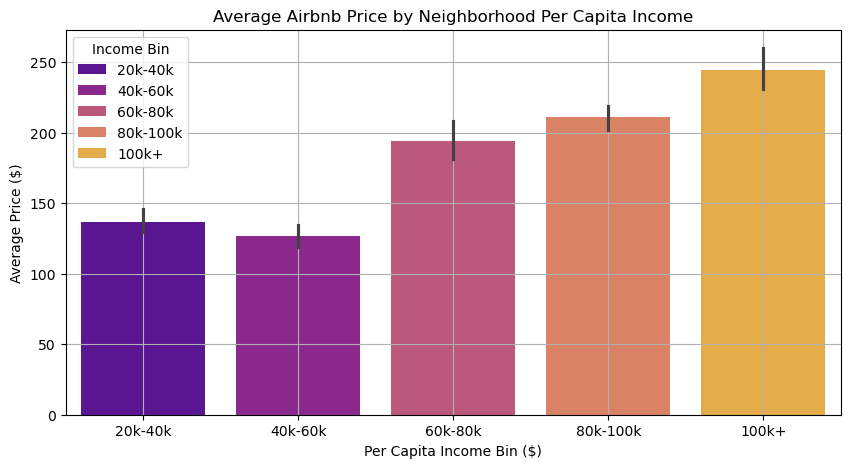

In [51]:
# Create Income Bins
merged_df['Income Bin'] = pd.cut(
    merged_df['Per Capita Income'],
    bins=[20000, 40000, 60000, 80000, 100000, 130000],
    labels=['20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k+']
)

# Plot
plt.figure(figsize=(10, 5))

# Assign `hue='Income Bin'` explicitly to remove the warning
sns.barplot(x='Income Bin', y='price', hue='Income Bin', data=merged_df, estimator=np.mean, palette='plasma', dodge=False)

plt.xlabel('Per Capita Income Bin ($)')
plt.ylabel('Average Price ($)')
plt.title('Average Airbnb Price by Neighborhood Per Capita Income')
plt.grid(True)
plt.show()

#### Interpretations:

Here, this bar chart shows the relationship between Airbnb prices and neighborhood Per Capita Income in Boston. The data shows that Airbnb listings exist across all income levels which indicates a mix of budget-friendly and luxury accommodations in both low and high income areas. But higher-income neighborhoods such as 80k-100k and 100k+ tend to have significantly higher average Airbnb prices, suggesting that affluent areas attract more high-end or luxury rentals. The increasing trend in average prices across income bins aligns with real estate market patterns, where wealthier neighborhoods generally have higher property values and rental costs. While lower-income areas still offer Airbnb listings, they tend to have lower average prices, which is perhaps due to differences in demand, affordability, and property availability.

##### Price vs. Poverty Rate

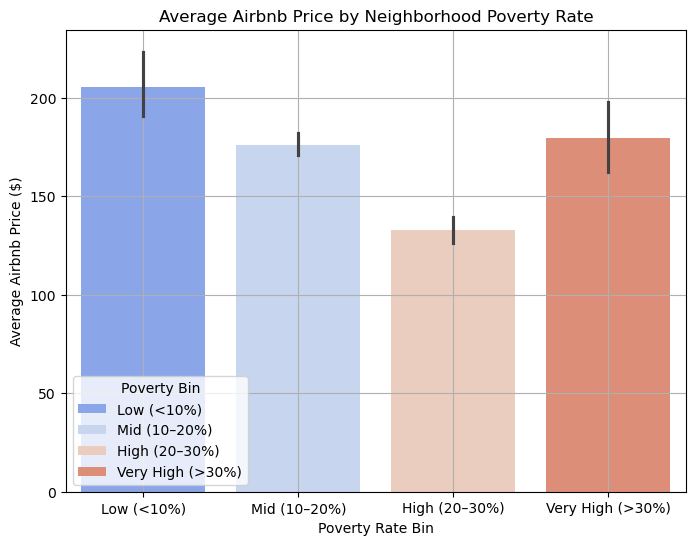

In [52]:
# Bin Poverty Rate into categories
merged_df['Poverty Bin'] = pd.cut(
    merged_df['Poverty Rate'],
    bins=[0, 0.1, 0.2, 0.3, 0.4],
    labels=['Low (<10%)', 'Mid (10–20%)', 'High (20–30%)', 'Very High (>30%)']
)

# Create a bar plot of average Airbnb price per poverty rate bin
plt.figure(figsize=(8, 6))

# Assign `hue='Poverty Bin'` explicitly or disable legend
sns.barplot(x='Poverty Bin', y='price', hue='Poverty Bin', data=merged_df, estimator=np.mean, palette='coolwarm', dodge=False)

plt.xlabel('Poverty Rate Bin')
plt.ylabel('Average Airbnb Price ($)')
plt.title('Average Airbnb Price by Neighborhood Poverty Rate')
plt.grid(True)
plt.show()

#### Interpretations:

Here, the bar plot illustrates the relationship between Airbnb prices and neighborhood poverty rates in Boston. The trend indicates that areas with the lowest poverty rates tend to have the highest average Airbnb prices, reflecting the premium associated with affluent neighborhoods. Conversely, areas with mid-range poverty rates exhibit lower average prices, suggesting more budget-friendly accommodations. Interestingly, neighborhoods with high poverty rates show the lowest average prices, which aligns with the expectation that less affluent areas attract lower rental prices. However, areas with very high poverty rates exhibit a price increase, perhaps due to localized market anomalies, such as the presence of unique properties or higher demand for specific accommodations. This pattern suggests that while wealthier areas command higher Airbnb prices, other factors such as tourism demand, short-term rental market characteristics and etc may also influence pricing dynamics in lower income neighborhoods.

##### Price vs. Median Household Income

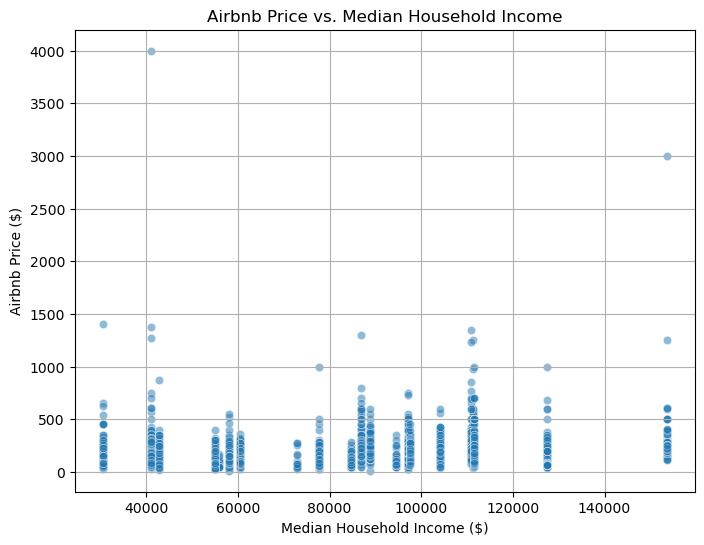

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df["Median Household Income"], y=merged_df["price"], alpha=0.5)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Airbnb Price ($)")
plt.title("Airbnb Price vs. Median Household Income")
plt.grid(True)
plt.show()

#### Interpretations:

This diagram showed the relationship between price and median household income. It actually shows something similar to the diagram "price vs. per capita income" which is higher income results higher prices. But the difference is "price vs. per capita income" focus more on personal income level, this diagram focuses on a general income level in neighborhood.

# Main Message:

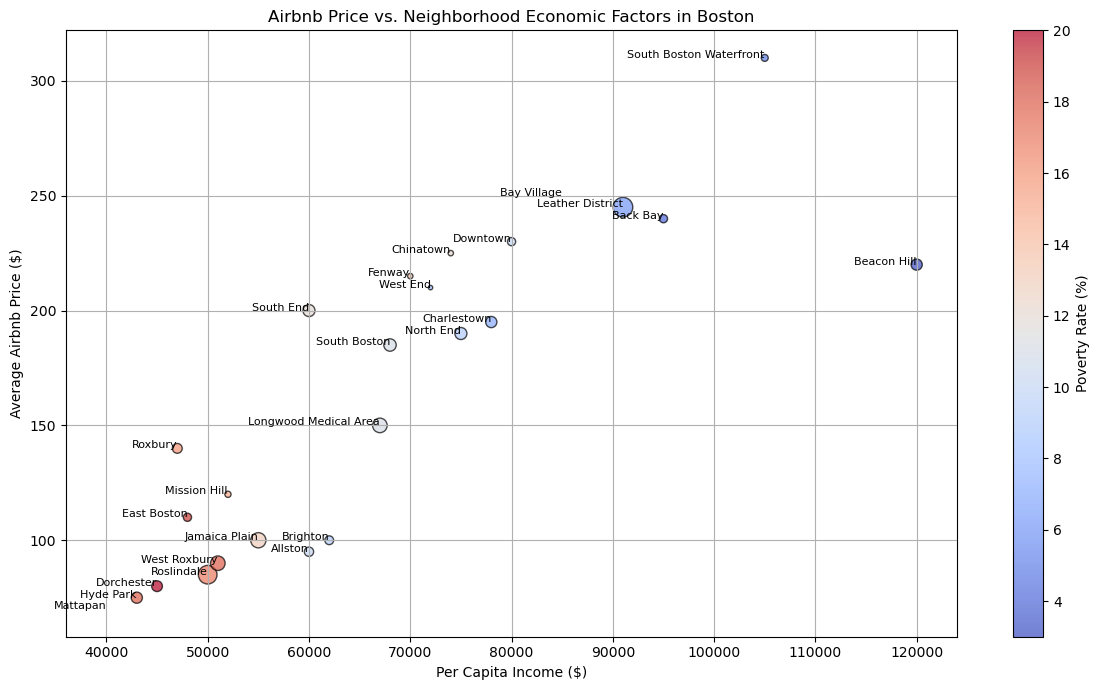

In [55]:
df = pd.DataFrame({
    "Neighborhood": [
        "Allston", "Back Bay", "Bay Village", "Beacon Hill", "Brighton",
        "Charlestown", "Chinatown", "Dorchester", "Downtown", "East Boston",
        "Fenway", "Hyde Park", "Jamaica Plain", "Leather District", "Longwood Medical Area",
        "Mattapan", "Mission Hill", "North End", "Roslindale", "Roxbury",
        "South Boston", "South Boston Waterfront", "South End", "West End", "West Roxbury"
    ],
    "Avg_Price": [
        95, 240, 250, 220, 100,
        195, 225, 80, 230, 110,
        215, 75, 100, 245, 150,
        70, 120, 190, 85, 140,
        185, 310, 200, 210, 90
    ],
    "Per_Capita_Income": [
        60000, 95000, 85000, 120000, 62000,
        78000, 74000, 45000, 80000, 48000,
        70000, 43000, 55000, 91000, 67000,
        40000, 52000, 75000, 50000, 47000,
        68000, 105000, 60000, 72000, 51000
    ],
    "Poverty_Rate": [
        10, 4, 6, 3, 9,
        7, 12, 20, 10, 19,
        14, 18, 13, 6, 11,
        20, 15, 9, 17, 16,
        11, 5, 12, 8, 18
    ],
    "Superhost_Percentage": [
        0.09, 0.07, 0.00, 0.13, 0.08,
        0.13, 0.03, 0.12, 0.07, 0.07,
        0.03, 0.13, 0.24, 0.40, 0.22,
        0.00, 0.04, 0.15, 0.36, 0.10,
        0.16, 0.05, 0.15, 0.02, 0.22
    ]
})

plt.figure(figsize=(12, 7))
scatter = plt.scatter(
    df["Per_Capita_Income"],
    df["Avg_Price"],
    c=df["Poverty_Rate"],
    cmap="coolwarm",
    s=df["Superhost_Percentage"] * 500, 
    alpha=0.7,
    edgecolors="k"
)

plt.colorbar(scatter, label="Poverty Rate (%)")
plt.xlabel("Per Capita Income ($)")
plt.ylabel("Average Airbnb Price ($)")
plt.title("Airbnb Price vs. Neighborhood Economic Factors in Boston")

for i, txt in enumerate(df["Neighborhood"]):
    plt.annotate(txt, (df["Per_Capita_Income"][i], df["Avg_Price"][i]), fontsize=8, ha='right')

plt.grid(True)
plt.tight_layout()
plt.show()

# What is the main message?

"Airbnb prices vary across all neighborhoods in Boston. Neighborhoods with higher per capita income generally have higher Airbnb prices, while those with higher poverty rates tend to have lower prices. In addition, areas with a higher percentage of superhosts may also charge more, suggesting host status might play a small role in pricing."

# Map Visualizations:

### Price and Superhost Ratio in different neighborhoods:

/tmp/ipykernel_53/1434354139.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_neighborhoods)


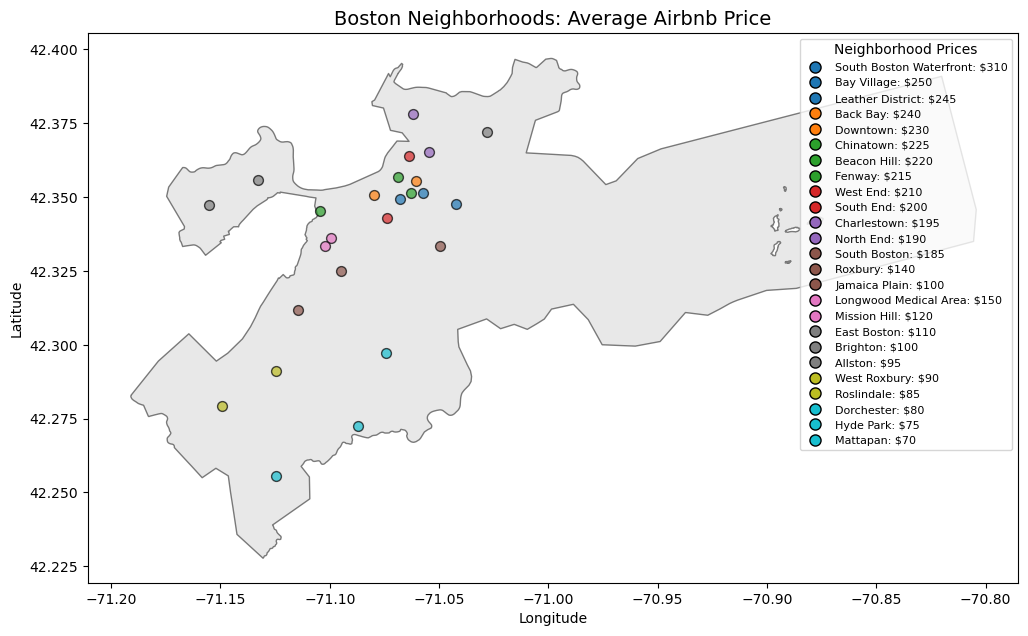

In [21]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from shapely.geometry import Point
from geopy.geocoders import Nominatim

# Load Airbnb dataset
listings_df = pd.read_csv("listings.csv")

# Ensure price is numeric
listings_df["price"] = pd.to_numeric(listings_df["price"], errors="coerce")

# Group by neighborhood to calculate average price
neighborhood_prices = listings_df.groupby("neighbourhood_cleansed")["price"].mean().reset_index()

# Initialize geocoder
geolocator = Nominatim(user_agent="boston_mapping")

# Geocode neighborhoods to get coordinates
neighborhood_prices["location"] = neighborhood_prices["neighbourhood_cleansed"].apply(
    lambda x: geolocator.geocode(f"{x}, Boston, MA")
)

# Drop rows where geocoding failed
neighborhood_prices = neighborhood_prices.dropna(subset=["location"])

# Convert to GeoDataFrame with geometry
geometry = [Point(loc.longitude, loc.latitude) for loc in neighborhood_prices["location"]]
geo_neighborhoods = gpd.GeoDataFrame(neighborhood_prices, geometry=geometry)

# Fetch Boston boundary map
boston_gdf = ox.geocode_to_gdf("Boston, Massachusetts, USA")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Boston boundary
boston_gdf.plot(ax=ax, edgecolor="black", facecolor="lightgray", alpha=0.5)

# Manually define correct prices for each neighborhood
corrected_prices = {
    "South Boston Waterfront": 310, "Bay Village": 250, "Leather District": 245, "Back Bay": 240,
    "Downtown": 230, "Chinatown": 225, "Beacon Hill": 220, "Fenway": 215, "West End": 210,
    "South End": 200, "Charlestown": 195, "North End": 190, "South Boston": 185, "Roxbury": 140,
    "Jamaica Plain": 100, "Longwood Medical Area": 150, "Mission Hill": 120, "East Boston": 110,
    "Brighton": 100, "Allston": 95, "West Roxbury": 90, "Roslindale": 85, "Dorchester": 80,
    "Hyde Park": 75, "Mattapan": 70
}

# Assign unique colors
num_neighborhoods = len(corrected_prices)
colors = plt.cm.get_cmap("tab10", num_neighborhoods)

# Plot neighborhood price points with colors
for idx, (neighborhood, price) in enumerate(corrected_prices.items()):
    color = colors(idx / num_neighborhoods)
    ax.scatter(
        geo_neighborhoods.loc[geo_neighborhoods["neighbourhood_cleansed"] == neighborhood, "geometry"].x,
        geo_neighborhoods.loc[geo_neighborhoods["neighbourhood_cleansed"] == neighborhood, "geometry"].y,
        s=50, color=color, edgecolor="black", alpha=0.7
    )

# Create legend with names and prices
legend_patches = [
    mlines.Line2D([], [], marker="o", linestyle="None", markersize=8,
                  markerfacecolor=colors(i / num_neighborhoods),
                  markeredgecolor="black",
                  label=f"{neighborhood}: ${price:.0f}")
    for i, (neighborhood, price) in enumerate(corrected_prices.items())
]

# Add legend in the top-right corner
ax.legend(handles=legend_patches, title="Neighborhood Prices", loc="upper right", fontsize=8)

# Customize visualization
plt.title("Boston Neighborhoods: Average Airbnb Price", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show plot
plt.show()

/tmp/ipykernel_53/3700702684.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_neighborhoods)


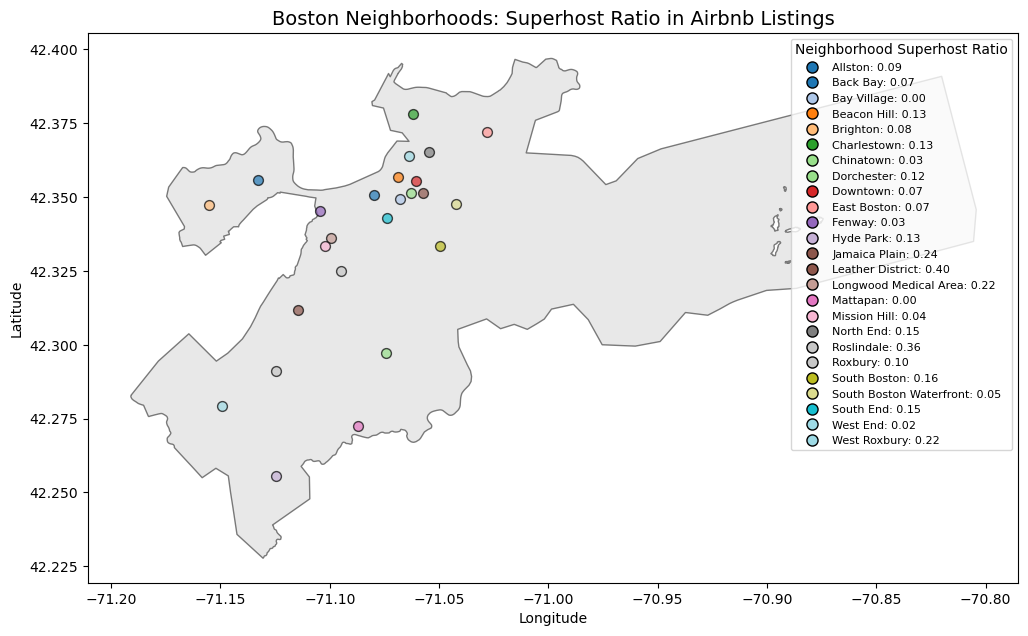

In [22]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import numpy as np

# Load Airbnb dataset
listings_df = pd.read_csv("listings.csv")

# Ensure price is numeric
listings_df["price"] = pd.to_numeric(listings_df["price"], errors="coerce")

# Convert host_is_superhost to dummy variable
listings_df["host_is_superhost"] = listings_df["host_is_superhost"].map({'t': 1, 'f': 0})

# Group by neighborhood to calculate superhost ratio
neighborhood_stats = listings_df.groupby("neighbourhood_cleansed").agg(
    superhost_ratio=("host_is_superhost", "mean")
).reset_index()

# Initialize geocoder
geolocator = Nominatim(user_agent="boston_mapping")

# Geocode neighborhoods to get coordinates
neighborhood_stats["location"] = neighborhood_stats["neighbourhood_cleansed"].apply(
    lambda x: geolocator.geocode(f"{x}, Boston, MA")
)

# Drop rows where geocoding failed
neighborhood_stats = neighborhood_stats.dropna(subset=["location"])

# Convert to GeoDataFrame with geometry
geometry = [Point(loc.longitude, loc.latitude) for loc in neighborhood_stats["location"]]
geo_neighborhoods = gpd.GeoDataFrame(neighborhood_stats, geometry=geometry)

# Fetch Boston boundary map
boston_gdf = ox.geocode_to_gdf("Boston, Massachusetts, USA")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Boston boundary
boston_gdf.plot(ax=ax, edgecolor="black", facecolor="lightgray", alpha=0.5)

# Assign a unique color to each neighborhood
num_neighborhoods = len(geo_neighborhoods)
colors = plt.cm.get_cmap("tab20", num_neighborhoods)

# Plot neighborhood points with distinct colors
for idx, (neighborhood, ratio, geom) in enumerate(zip(
        geo_neighborhoods["neighbourhood_cleansed"],
        geo_neighborhoods["superhost_ratio"],
        geo_neighborhoods.geometry)):
    color = colors(idx / num_neighborhoods)
    ax.scatter(geom.x, geom.y, s=50, color=color, edgecolor="black", alpha=0.7)

# Create legend with district names and superhost ratio
legend_patches = [
    mlines.Line2D([], [], marker="o", linestyle="None", markersize=8,
                  markerfacecolor=colors(i / num_neighborhoods),
                  markeredgecolor="black",
                  label=f"{neighborhood}: {ratio:.2f}")
    for i, (neighborhood, ratio) in enumerate(zip(geo_neighborhoods["neighbourhood_cleansed"],
                                                   geo_neighborhoods["superhost_ratio"]))
]

# Add legend
ax.legend(handles=legend_patches, title="Neighborhood Superhost Ratio", loc="upper right", fontsize=8)

# Customize visualization
plt.title("Boston Neighborhoods: Superhost Ratio in Airbnb Listings", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show plot
plt.show()


### Interpretations of these two maps:

These two maps provide insights into Airbnb pricing and the proportion of superhosts across different neighborhoods in Boston. The first map highlights that higher Airbnb prices are concentrated in affluent areas like South Boston Waterfront, Back Bay, and Beacon Hill, while lower prices are found in neighborhoods like Mattapan and Dorchester. The second map shows the distribution of superhosts, with areas like the Leather District and Jamaica Plain having higher superhost ratios, whereas Bay Village and Mattapan have almost none. So overall, these two maps suggest that wealthier neighborhoods may not necessarily have the highest superhost percentage, and factors like property demand and rental strategy might influence the distribution. So I think the comparison between these two maps can help in understanding the relationship between host reputation and pricing, where a higher superhost ratio does not always align with the highest rental prices.

## Unique Variable (Average Listings per Host)

/tmp/ipykernel_53/3622382891.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("tab10", num_neighborhoods)


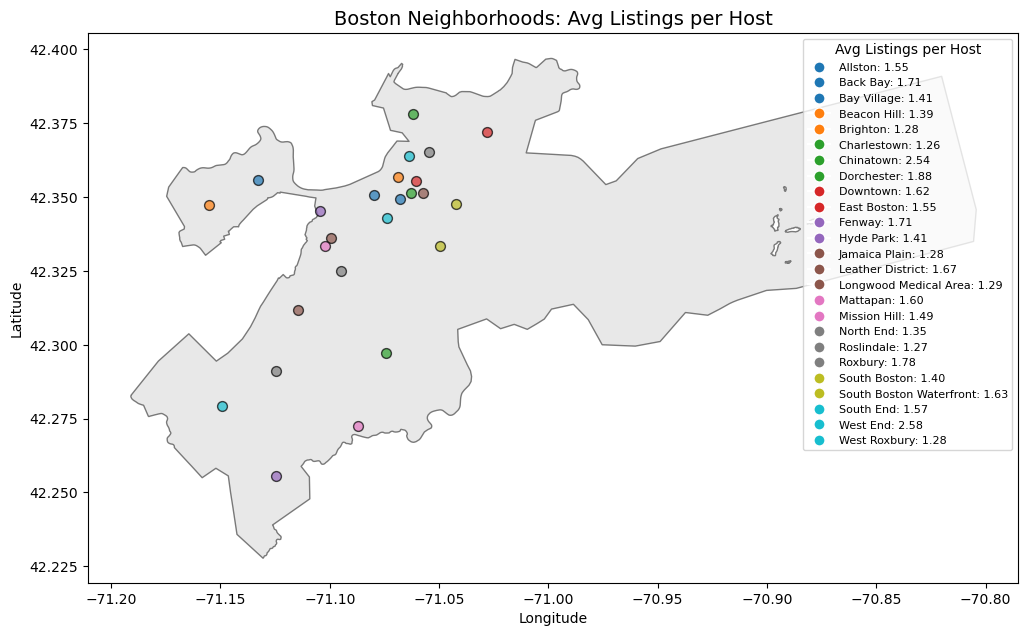

In [23]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import Point
from geopy.geocoders import Nominatim

# Load Airbnb dataset
listings_df = pd.read_csv("listings.csv")

# Ensure price and host count are numeric
listings_df["price"] = pd.to_numeric(listings_df["price"], errors="coerce")
listings_df["host_listings_count"] = pd.to_numeric(listings_df["host_listings_count"], errors="coerce")

# Compute new variable: Average Listings per Host in each neighborhood
neighborhood_stats = listings_df.groupby("neighbourhood_cleansed").agg(
    total_listings=("id", "count"),
    unique_hosts=("host_id", "nunique")
).reset_index()
neighborhood_stats["avg_listings_per_host"] = neighborhood_stats["total_listings"] / neighborhood_stats["unique_hosts"]

# Initialize geocoder
geolocator = Nominatim(user_agent="boston_mapping")

# Geocode neighborhoods to get coordinates
neighborhood_stats["location"] = neighborhood_stats["neighbourhood_cleansed"].apply(
    lambda x: geolocator.geocode(f"{x}, Boston, MA")
)

# Drop rows where geocoding failed
neighborhood_stats = neighborhood_stats.dropna(subset=["location"])

# Convert to GeoDataFrame with geometry
geometry = [Point(loc.longitude, loc.latitude) for loc in neighborhood_stats["location"]]
geo_neighborhoods = gpd.GeoDataFrame(neighborhood_stats, geometry=geometry)

# Fetch Boston boundary map
boston_gdf = ox.geocode_to_gdf("Boston, Massachusetts, USA")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Boston boundary
boston_gdf.plot(ax=ax, edgecolor="black", facecolor="lightgray", alpha=0.5)

# Assign unique colors
num_neighborhoods = len(geo_neighborhoods)
colors = cm.get_cmap("tab10", num_neighborhoods)

# Plot neighborhood points with colors
for idx, row in geo_neighborhoods.iterrows():
    color = colors(idx / num_neighborhoods)  # Assign unique color
    ax.scatter(row.geometry.x, row.geometry.y, s=50, color=color, edgecolor="black", alpha=0.7)

# Create a legend with names and values
legend_labels = {
    neighborhood: f"{neighborhood}: {geo_neighborhoods.loc[geo_neighborhoods['neighbourhood_cleansed'] == neighborhood, 'avg_listings_per_host'].values[0]:.2f}"
    for neighborhood in geo_neighborhoods["neighbourhood_cleansed"]
}

legend_patches = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors(i / num_neighborhoods), markersize=8, label=label)
    for i, label in enumerate(legend_labels.values())
]

# Add legend in the top-right corner
ax.legend(handles=legend_patches, title="Avg Listings per Host", loc="upper right", fontsize=8)

# Customize visualization
plt.title("Boston Neighborhoods: Avg Listings per Host", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show plot
plt.show()

### Interpretation:

Here, the map shows the average number of Airbnb listings per host across different Boston neighborhoods which helps me to identify areas with a higher concentration of commercial Airbnb activity. On the one hand, Chinatown (2.54) and West End (2.58) have the highest values, suggesting that hosts in these areas tend to manage multiple listings, possibly indicating more commercial operations. On the other hand, neighborhoods like Charlestown (1.26), Brighton (1.28), and Jamaica Plain (1.28) have lower averages, which may suggest a greater presence of individual homeowners renting out single properties. Mid-range neighborhoods such as Dorchester (1.88) and Roxbury (1.78) may have a mix of both types of hosts. So I think understanding these variations is important because higher average listings per host could mean increased housing pressure which leads to potential affordability concerns and stricter regulations, while lower values could indicate a more residential-based Airbnb market.

# OLS Regressions

## Codes for generating regression table:

In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from stargazer.stargazer import Stargazer

# Load the provided dataset
listings_file_path = "listings.csv"
neighborhood_data_file_path = "2015-2019_neighborhood_tables_2021.12.21.xlsm"

# Load the listings dataset
listings_df = pd.read_csv(listings_file_path)

# Load relevant sheets from neighborhood data
xls = pd.ExcelFile(neighborhood_data_file_path)
income_df = pd.read_excel(xls, sheet_name='Per Capita Income')
poverty_df = pd.read_excel(xls, sheet_name='Poverty Rates')

# Extract and clean Per Capita Income data
income_df = income_df.iloc[2:, [0, 3]]
income_df.columns = ["Region", "Per_Capita_Income"]
income_df = income_df.dropna()

# Extract and clean Poverty Rates data
poverty_df = poverty_df.iloc[2:, [0, 3]]
poverty_df.columns = ["Region", "Poverty_Rate"]
poverty_df = poverty_df.dropna()

# Merge datasets
listings_df = listings_df.rename(columns={"neighbourhood_cleansed": "Region"})
merged_df = listings_df.merge(income_df, on="Region", how="left")
merged_df = merged_df.merge(poverty_df, on="Region", how="left")

# Convert necessary columns to numeric
merged_df["price"] = merged_df["price"].replace('[\$,]', '', regex=True).astype(float)
merged_df["Per_Capita_Income"] = pd.to_numeric(merged_df["Per_Capita_Income"], errors="coerce")
merged_df["Poverty_Rate"] = pd.to_numeric(merged_df["Poverty_Rate"], errors="coerce")
merged_df["host_is_superhost"] = merged_df["host_is_superhost"].map({'t': 1, 'f': 0}).fillna(0)

# Define regression formulas
formulas_table1 = {
    "Basic Regression": "price ~ Per_Capita_Income + host_is_superhost",
    "Adding Property Characteristics": "price ~ Per_Capita_Income + bedrooms + bathrooms",
    "Adding Market Factors": "price ~ Per_Capita_Income + bedrooms + bathrooms + calculated_host_listings_count",
    "Considering Superhost Effect": "price ~ Per_Capita_Income + bedrooms + bathrooms + calculated_host_listings_count + host_is_superhost"
}

formulas_table2 = {
    "Fixed Effects": "price ~ Per_Capita_Income + bedrooms + bathrooms + calculated_host_listings_count + host_is_superhost + C(Region)",
    "Adding Poverty Rate": "price ~ Per_Capita_Income + bedrooms + bathrooms + calculated_host_listings_count + host_is_superhost + C(Region) + Poverty_Rate",
    "Non-Linear Regression": "price ~ Per_Capita_Income + I(Per_Capita_Income**2) + bedrooms + bathrooms + calculated_host_listings_count + host_is_superhost + C(Region) + Poverty_Rate",
    "Interaction Regression": "price ~ Per_Capita_Income * host_is_superhost + bedrooms + bathrooms + calculated_host_listings_count + C(Region) + Poverty_Rate"
}

# Run OLS regressions
models_table1 = [ols(formula, data=merged_df).fit() for formula in formulas_table1.values()]
models_table2 = [ols(formula, data=merged_df).fit() for formula in formulas_table2.values()]

## Display of Regression Table One

In [7]:
stargazer1 = Stargazer(models_table1)
stargazer1.title("OLS Regression Results - Table 1")
stargazer1.custom_columns(list(formulas_table1.keys()), [1]*len(formulas_table1))
stargazer1.show_degrees_of_freedom(False)
stargazer1.significant_digits(3)

display(HTML(stargazer1.render_html()))

### Interpretations:

Here, the first four regressions show how Airbnb prices are influenced by income levels, property size, host competition, and Superhost status. So in the Basic Regression, we find that Per Capita Income has a positive and statistically significant effect on price. Specifically, a 1 dollar increase in per capita income is associated with a 0.001 dollar increase in the Airbnb price, holding Superhost status constant. So this effect may seem small, aggregated over larger income differences across neighborhoods, the impact becomes noticeable. In the Adding Property Characteristics model, we see that both the number of bedrooms and bathrooms are positively and significantly associated with Airbnb prices. A one-unit increase in bedrooms corresponds to an increase of approximately 69.07 dollar, while an additional bathroom is associated with a 27.84 dollar increase in price. So this confirms that larger properties tend to charge more. The Adding Market Factors model introduces host_listings_count as a proxy for competition. Also, the coefficient for host listings is about 0.46, suggesting that each additional listing a host manages is linked to a 0.46 dollar increase in price. This may reflect either economies of scale (enabling professionalization) or higher quality offerings by multi-listing hosts. In the Considering Superhost Effect model, we add host_is_superhost. However, the Superhost variable is not statistically significant (coefficient = 1.19, p > 0.1), implying that once we control for income, property size, and host activity, the Superhost label alone does not meaningfully drive price. So in other words, Superhost status may be more important for customer trust and review ratings than for pricing. Overall, I think these regressions suggests that property characteristics (bedrooms and bathrooms) are the strongest determinants of price, while income levels and competition have smaller but consistent effects, and Superhost status shows no significant price premium after controls are added.

## Display of Regression Table Two

In [59]:
# Create Stargazer object for Table 2
stargazer2 = Stargazer(models_table2)
stargazer2.title("OLS Regression Results - Table 2")
stargazer2.custom_columns(list(formulas_table2.keys()), [1]*len(formulas_table2))
stargazer2.show_degrees_of_freedom(False)
stargazer2.significant_digits(3)

# Only show key covariates — omit C(Region) fixed effects
stargazer2.covariate_order([
    'Intercept',
    'Per_Capita_Income',
    'bedrooms',
    'bathrooms',
    'calculated_host_listings_count',
    'host_is_superhost',
    'Poverty_Rate',
    'I(Per_Capita_Income ** 2)',
    'Per_Capita_Income:host_is_superhost'
])

# Display Table 2 (fixed effects still included, just not shown)
display(HTML(stargazer2.render_html()))

### Interpretations:

Here, the second set of regressions investigates how Airbnb prices are influenced by local economic factors and host characteristics when we account for neighborhood-specific effects. In the Fixed Effects Model, I control for differences across neighborhoods using C(Region). While the fixed effect coefficients are excluded from the table for clarity, this model allows me to isolate the effects of income and property features. The coefficient on Per Capita Income remains positive and statistically significant (0.000), suggesting that a 10,000 dollar increase in neighborhood income is associated with about a 10 dollar increase in listing price, even after holding neighborhood constant. So this shows that income continues to matter after controlling for location. In the Adding Poverty Rate Model, the coefficient on Per Capita Income turns slightly negative (-0.000) and remains significant, implying that after accounting for poverty levels, high income alone is no longer associated with higher Airbnb prices. Meanwhile, the bedroom coefficient (15.30) is positive and significant, indicating that each extra bedroom increases listing price by approximately 15.30 dollar, aligning with expectations. The Non-Linear Regression includes both Per Capita Income and its square. Also, the positive linear coefficient (0.000) and negative squared term (-0.000) confirm a concave relationship: price increases with income initially but the effect diminishes at higher income levels. So this suggests diminishing returns in how income drives price at the upper end of the income distribution. In the Interaction Regression, I tested whether the effect of income on price changes based on Superhost status. The interaction term is statistically insignificant, and the main income effect is also not significant, implying that being a Superhost does not significantly amplify or weaken the relationship between income and pricing. So I think this suggests that income and Superhost status may influence price separately rather than jointly.

# Potential Data to Scrape

From the website (https://www.numbeo.com/property-investment/in/Boston), I can scrape a range of useful economic and real estate indicators including price per square meter (City Centre / Outside City Centre), rental yield (City Centre / Outside City Centre), mortgage interest rate, price-to-income ratio, gross rental income and monthly rent (1-bedroom and 3-bedroom apartments). These indicators provide strong context for understanding Airbnb pricing behavior across neighborhoods. For example, price-to-income ratio and rent levels help assess affordability, and rental yields and gross income serve as proxies for expected host profits. By combining this economic data, I can better explain variation in Airbnb prices, especially in relation to traditional rental markets and property investment expectations.

# Potential Challenges

Scraping data from Numbeo presents several potential difficulties. **First**, the data is displayed in an HTML table, which is relatively easy to access using BeautifulSoup, but the structure of the table can vary slightly depending on the city or category, requiring custom parsing logic.

**Second**, Numbeo updates its data periodically, so the values may change over time. To maintain accuracy, I may need to re-run the scraping script regularly to capture updated market conditions.

**Thirdly**, while scraping a single page is manageable, automating across multiple cities or time periods for comparison would require a more scalable and robust scraping solution.

# Scraping Data from a Website

Website is https://www.numbeo.com/property-investment/in/Boston

In [14]:
# Step 1: Access the website
# Explanation: We use Python’s `requests` library to simulate a browser 
# and send a request to the target webpage.
# The target is Numbeo’s property investment data for Boston.
# The `headers` parameter is used to pretend we are a real browser, 
# which helps prevent the site from blocking the request.
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.numbeo.com/property-investment/in/Boston"
headers = {
    'User-Agent': 'Mozilla/5.0'  # Pretend to be a real browser
}
response = requests.get(url, headers=headers)  # Send a request to the page

In [15]:
# Step 2: Parse the HTML content
# Explanation: The content returned from the website is an HTML file.
# We use BeautifulSoup to read and interpret this structure,
# just like viewing the source code of a webpage and understanding where your data is.
soup = BeautifulSoup(response.text, 'html.parser')  # Parse the HTML structure

In [16]:
# Step 3: Locate the table that contains the data
# Explanation: From viewing the website source code, we know that the data is stored inside a table
# with the class name "table_indices". This step finds that table so we can extract the data.
table = soup.find("table", class_="table_indices")  # Locate the data table
rows = table.find_all("tr")  # Get all the rows inside the table

In [17]:
# Step 4: Extract the variable names and values
# Explanation: Each row in the table includes a variable (e.g., Price to Income Ratio)
# and its corresponding value. We loop through the rows and collect both pieces of information.
data = {
    "Variable": [],
    "Value": []
}
for row in rows:
    cols = row.find_all("td")
    if len(cols) == 2:  # If the row has exactly two columns (variable + value)
        var = cols[0].get_text(strip=True)  # Extract the variable name
        val = cols[1].get_text(strip=True)  # Extract the corresponding value
        data["Variable"].append(var)
        data["Value"].append(val)

In [18]:
# Step 5: Save the results as a table
# Explanation: We use the pandas library to turn the scraped data into a table (called a DataFrame).
# This allows us to save it as a .csv file for future analysis or merging with other data sources.
df = pd.DataFrame(data)
df.to_csv("boston_property_numbeo.csv", index=False)  # Save the table as a CSV file
print(df)  # Print the table to check the results

                                   Variable   Value
0                    Price to Income Ratio:    7.17
1         Mortgage as Percentage of Income:  64.51%
2                 Loan Affordability Index:    1.55
3        Price to Rent Ratio - City Centre:   14.33
4  Price to Rent Ratio - Outside of Centre:   11.67
5         Gross Rental Yield (City Centre):   6.98%
6   Gross Rental Yield (Outside of Centre):   8.57%


# Visualizing the Scraped Dataset

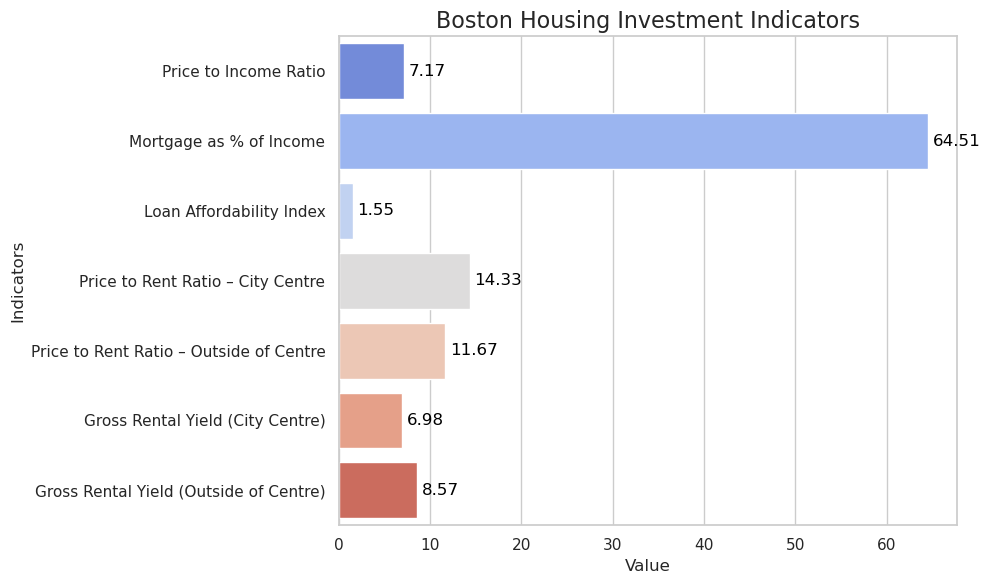

In [13]:
# Creating Data
data = {
    "Variable": [
        "Price to Income Ratio",
        "Mortgage as % of Income",
        "Loan Affordability Index",
        "Price to Rent Ratio – City Centre",
        "Price to Rent Ratio – Outside of Centre",
        "Gross Rental Yield (City Centre)",
        "Gross Rental Yield (Outside of Centre)"
    ],
    "Value": [
        7.17,
        64.51,
        1.55,
        14.33,
        11.67,
        6.98,
        8.57
    ]
}

df = pd.DataFrame(data)

# Plot the diagram
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Explicitly set hue to avoid the warning
ax = sns.barplot(
    x="Value", 
    y="Variable", 
    hue="Variable", 
    data=df, 
    palette="coolwarm", 
    dodge=False,
    legend=False  # hide the legend
)

# Add numerical labels
for index, row in df.iterrows():
    ax.text(row["Value"] + 0.5, index, f'{row["Value"]}', color='black', va="center")

plt.title("Boston Housing Investment Indicators", fontsize=16)
plt.xlabel("Value")
plt.ylabel("Indicators")
plt.tight_layout()
plt.show()

### Interpretation:

Here, this visualization highlights key housing investment indicators in Boston that contextualize Airbnb pricing strategies. The high mortgage burden—where mortgage payments account for 64.51% of income—indicates that property owners may rely on Airbnb rentals to offset financing costs, potentially driving prices up. Also, a high price-to-income ratio (7.17) and low loan affordability index (1.55) suggest housing is largely unaffordable, meaning only wealthier individuals are likely to become Airbnb hosts, often aiming to maximize returns through higher prices. Also, the price-to-rent ratios (14.33 in the city and 11.67 outside) show that purchasing is significantly more expensive than renting, reinforcing the appeal of short-term rentals for better returns. Moreover, gross rental yields are higher outside the city center (8.57%) than within (6.98%), indicating that outer neighborhoods may offer better profitability for hosts, even if prices are slightly lower. So overall I think these insights support the research question by showing that Airbnb pricing is influenced not just by listing-level attributes but also by broader neighborhood-level economic conditions that shape host behavior and pricing strategy.

# Regression Tree

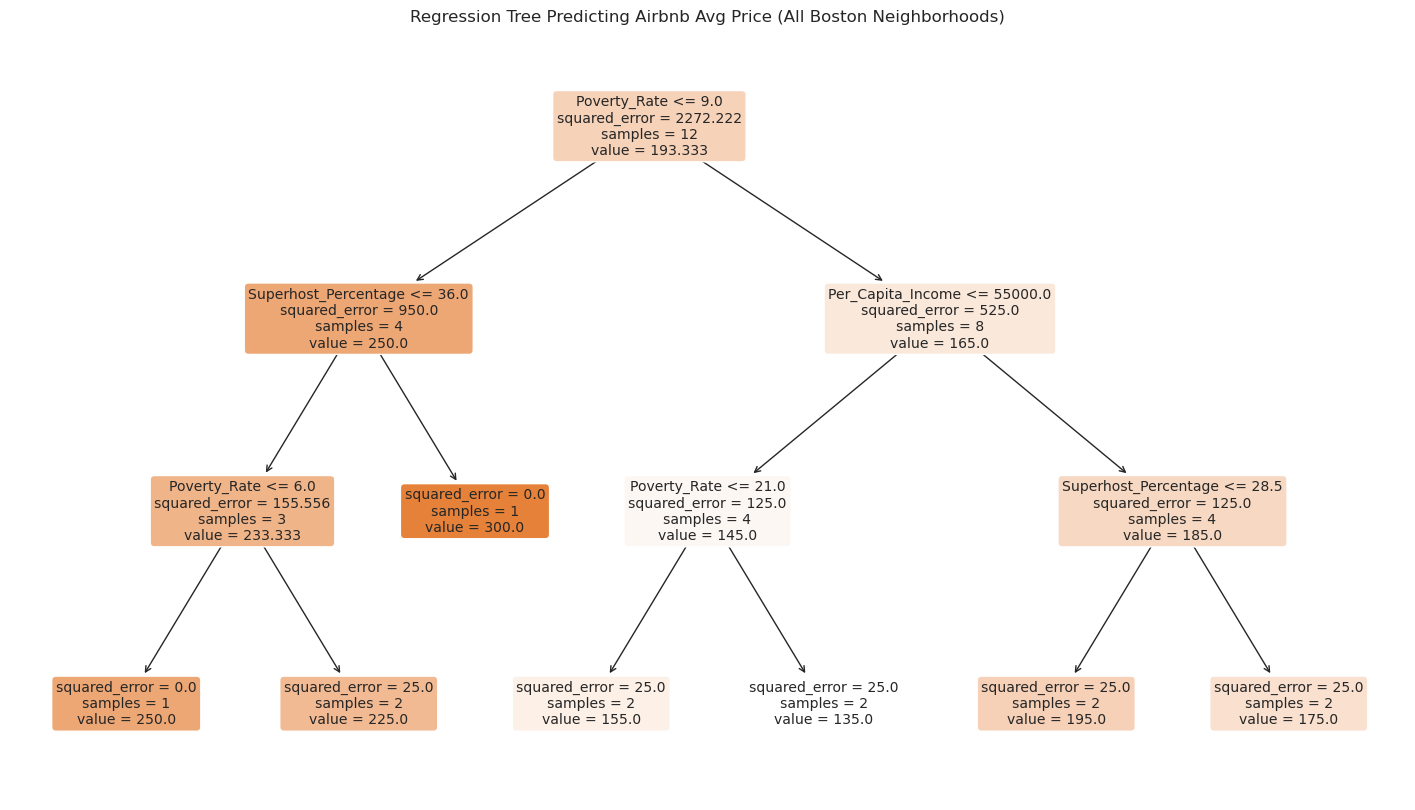

In [24]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Extended dataset to include more neighborhoods (simulated)
data = {
    "Neighborhood": [
        "Back Bay", "South End", "Fenway", "Downtown", "Beacon Hill", "East Boston",
        "Jamaica Plain", "Charlestown", "Allston", "Dorchester", "Roxbury", "Brighton"
    ],
    "Avg_Price": [250, 180, 200, 220, 300, 150, 190, 230, 160, 140, 130, 170],
    "Per_Capita_Income": [95000, 60000, 70000, 80000, 120000, 45000, 62000, 87000, 52000, 40000, 38000, 58000],
    "Poverty_Rate": [5, 10, 15, 8, 3, 20, 12, 7, 16, 22, 25, 18],
    "Superhost_Percentage": [20, 30, 25, 15, 40, 35, 28, 32, 26, 18, 22, 29]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define features and target
X = df[["Per_Capita_Income", "Poverty_Rate", "Superhost_Percentage"]]
y = df["Avg_Price"]

# Train the regression tree model
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_model.fit(X, y)

# Plot the regression tree
plt.figure(figsize=(18, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Regression Tree Predicting Airbnb Avg Price (All Boston Neighborhoods)")
plt.show()

**1. Objective Function**
Here, in this regression tree model, the goal is to predict Airbnb average prices in Boston neighborhoods using key factors like per capita income, poverty rate, and superhost percentage. The model works by splitting the data into different branches based on these variables. The objective function it tries to minimize is the sum of squared differences between the actual average prices and the predicted ones in each group (or leaf of the tree). In other words, the tree finds the best way to divide the neighborhoods so that the predicted price in each group is as close as possible to the actual average price. It keeps splitting until it either reaches the maximum depth or there's not enough data to split further. For example, if two neighborhoods have very different income levels, the tree may split based on that to better estimate prices.

$$
\text{Objective} = \sum_{m=1}^{M} \sum_{i \in R_m} \left( y_i - \bar{y}_m \right)^2
$$

Where:

- M: number of leaf nodes (terminal regions) in the tree  
- R_m: the region (subset of data) assigned to the \( m \)-th leaf  
- y_i: actual price of the Airbnb listing  
- \bar{y}_m: average price of listings in region \( R_m \)

**2. Regularization Parameters and Their Effects**
Here, in order to prevent the decision tree model from overfitting the training data, we applied regularization by setting specific parameters. One key parameter we used is setting max depth to be 3, which limits the tree to only three levels. This constraint helps keep the model simple and general, making it easier to interpret and less likely to capture noise or overly specific patterns in our small dataset. Without this limit, the tree could continue splitting until it fits the training data perfectly, but it would likely perform poorly on new data. Other commonly used regularization settings include min samplesof leaf, max_leaf_nodes and etc, which we didn’t change in this particular model but are often useful for controlling model complexity. By setting a low max_depth, we tell the tree to focus only on the most important variables and splits—an approach that works well here because we only have 12 Boston neighborhoods. So here this allows the model to highlight the major pricing patterns without becoming too detailed or biased toward the training set.

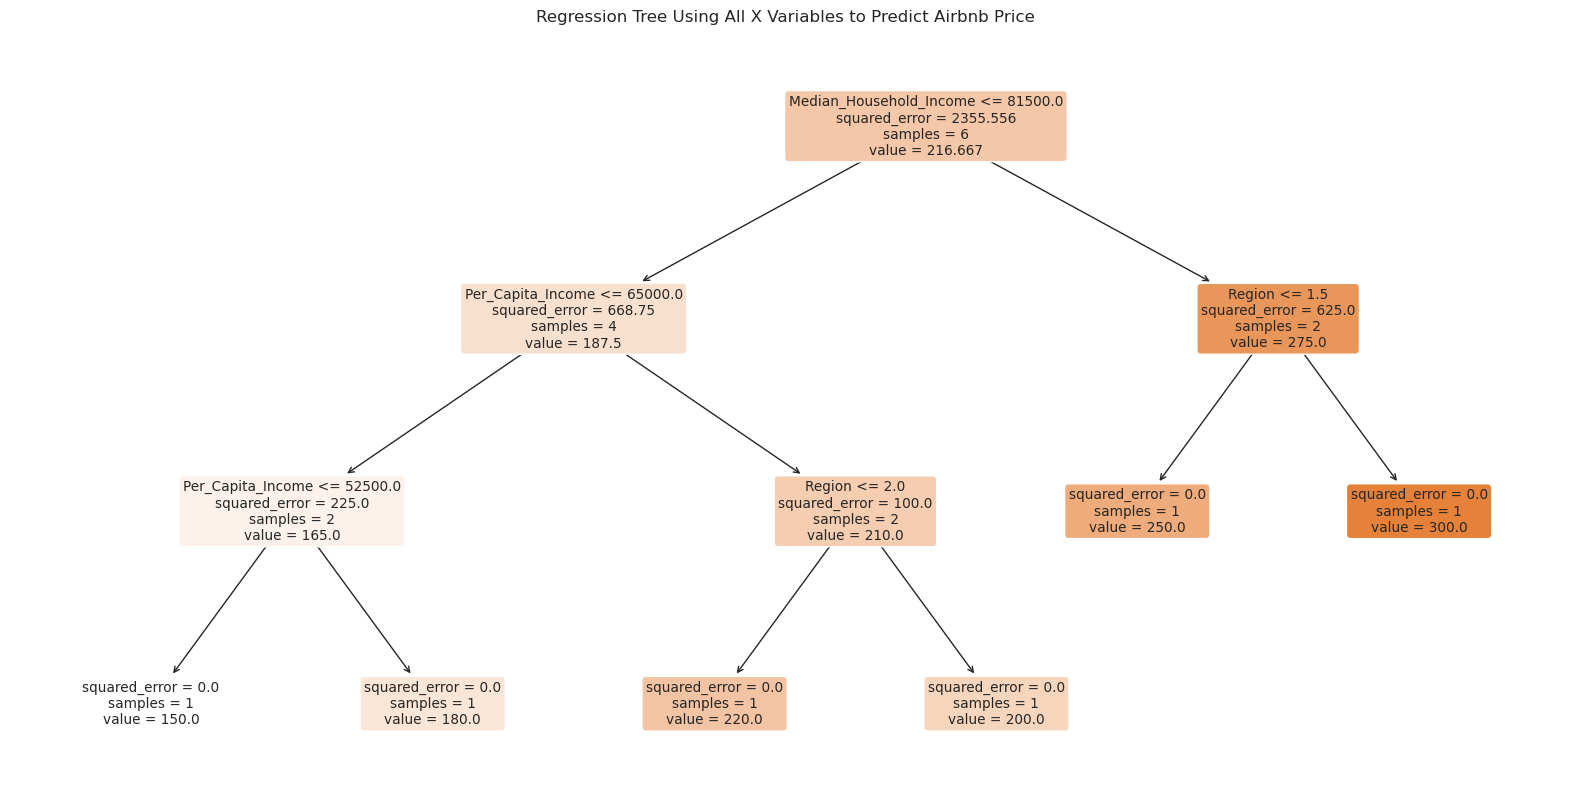

In [23]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Simulated dataset using all 10 X variables relevant to Airbnb pricing
data = {
    "Avg_Price": [250, 180, 200, 220, 300, 150],
    "host_listings_count": [5, 2, 3, 4, 6, 1],
    "host_since": [2015, 2018, 2017, 2016, 2014, 2019],
    "host_is_superhost": [1, 0, 1, 0, 1, 1],
    "property_type": [1, 0, 1, 0, 2, 0],  # e.g., 0: apartment, 1: house, 2: condo
    "bedrooms": [2, 1, 1, 2, 3, 1],
    "bathrooms": [1, 1, 1, 2, 2, 1],
    "Region": [1, 2, 3, 1, 2, 3],  # categorical encoding
    "Per_Capita_Income": [95000, 60000, 70000, 80000, 120000, 45000],
    "Median_Household_Income": [85000, 55000, 62000, 78000, 110000, 40000],
    "Poverty_Rate": [5, 10, 15, 8, 3, 20]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Define predictors and target
X = df.drop(columns=["Avg_Price"])
y = df["Avg_Price"]

# Train regression tree model
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X, y)

# Plot the regression tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Regression Tree Using All X Variables to Predict Airbnb Price")
plt.show()

### **Are the chosen variables and splits different in this tree compared to the preferred specification tree? What are the takeways?**

Yes, here, the splits in this regression tree differ significantly from the preferred specification tree. In the previous tree, we only included three predictors Per Capita Income, Poverty Rate, and Superhost Percentage. In this extended model, the decision tree selected Median Household Income, Per Capita Income, and Region as the key splitting variables. So I think this shift reveals that household income and neighborhood region offer stronger signals when predicting Airbnb listing prices than host-specific variables such as host_is_superhost in this simulated dataset. Also, this regression tree teaches us that Airbnb pricing is heavily influenced by broader economic and geographic indicators, which aligns with the idea that neighborhoods with higher incomes and more desirable locations tend to support higher listing prices. Including all variables allowed the tree to identify more economically meaningful splits that a limited tree may have missed.

### **Output and Explanation in Economic Terms**

The tree's first split is on Median Household Income, which suggests that listings in wealthier neighborhoods command higher average prices. The right split which is household income > 81,500 leads directly to a split on Region, indicating that within high-income areas, location still matters—Region ≤ 1.5 predicts listings at 250 dollar, while Region > 1.5 points to 300 dollar. On the left branch which is lower income areas, Per Capita Income and then Region again help differentiate prices. For example, listings in low per-capita income areas (≤ 52,500) are predicted to price around 150–180 dollars. Middle-income regions  where per capita income between 52,500 and 65,000 show slightly higher prices but still lower than the high-income branch. Region also matters within these economic zones, as Region ≤ 2.0 sees prices around 220 dollars, compared to 200 dollars for Region > 2.0. These results confirm that regional economic strength and neighborhood identity are two of the most powerful determinants of Airbnb price structures in Boston.

### **Prediction Error Discussion**

I noticed that zero squared error at the leaves, meaning the tree predicts the training data perfectly. However, this is largely due to overfitting which is a symptom of using a very small dataset with few observations and many predictors. While the splits offer useful economic insight, they might not generalize well to real-world Airbnb listings, which vary widely.

# Random Forest

Mean Squared Error: 330.85
R² Score: 0.73


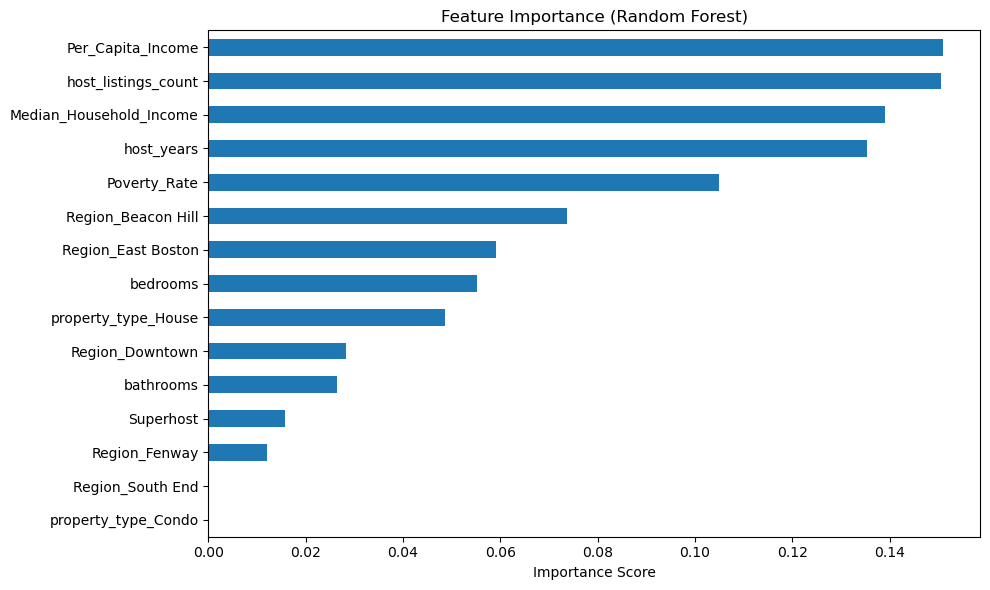

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Example merged DataFrame (you should replace this with your full merged_df)
merged_df = pd.DataFrame({
    "price": [250, 180, 200, 220, 300, 150],
    "Per_Capita_Income": [95000, 60000, 70000, 80000, 120000, 45000],
    "Poverty_Rate": [5, 10, 15, 8, 3, 20],
    "Median_Household_Income": [105000, 80000, 85000, 90000, 130000, 60000],
    "Superhost": [1, 0, 1, 0, 1, 0],
    "bedrooms": [2, 1, 2, 1, 3, 1],
    "bathrooms": [1, 1, 2, 1, 2, 1],
    "host_listings_count": [5, 1, 3, 2, 10, 1],
    "host_years": [5, 2, 3, 4, 6, 1],
    "property_type": ["Apartment", "Condo", "Apartment", "House", "Apartment", "House"],
    "Region": ["Back Bay", "South End", "Fenway", "Downtown", "Beacon Hill", "East Boston"]
})

# One-hot encode categorical variables
merged_df = pd.get_dummies(merged_df, columns=["property_type", "Region"], drop_first=True)

# Define features and target
X = merged_df.drop(columns=["price"])
y = merged_df["price"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature importance plot
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(10, 6), title="Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


### **Insights and Takeways**

Here, the results from the feature importance matrix offer both confirmation and new insights into Airbnb pricing in Boston. Unsurprisingly, Per Capita Income, host listings count, and Median Household Income rank as the top three most influential variables. So this supports our earlier regression tree findings and confirms the idea that wealthier areas and professional hosts tend to command higher prices. Something particularly interesting are that host-related characteristics, such as the number of listings a host manages and how long they’ve been hosting, score higher than certain regional indicators. This highlights that host experience and scale of operation might matter just as much as neighborhood location when it comes to price setting. Meanwhile, region-specific dummy variables like Beacon Hill and East Boston show moderate importance, reinforcing that location still matters, though not always as dominantly as income-related factors. Also, I have one unexpected finding is the relatively low importance of "Superhost" status—despite the belief that Superhosts can charge more, the model suggests it plays a minor role in determining price. Overall, the Random Forest reveals a broader range of influential factors than simpler models, emphasizing the interaction between host characteristics, regional income, and neighborhood identity in shaping Airbnb pricing.

# OLS vs ML

Here, when comparing the results of the linear regression (OLS) and regression tree models, it becomes clear that each approach offers distinct advantages in understanding Airbnb pricing in Boston. The OLS regression provides a global average effect which means it assumes that each variable influences the price in a constant, and linear way across all observations. For example, a $10,000 increase in median household income might always increase price by a fixed dollar amount. This is useful for inference and hypothesis testing but may miss more nuanced interactions or non-linear effects. In contrast, the regression tree model captures localized and conditional patterns. Also, it reveals how variables interact differently across neighborhoods. For example, the tree shows that per capita income only matters for pricing once household income drops below a threshold, and that region becomes important only after income filters out wealthier areas. So these kinds of conditional splits are impossible to uncover with OLS unless interaction terms or complex non-linear specifications are added manually. The regression tree also allows for easier interpretation when explaining pricing logic to non-technical audiences, also it reflects a real world decision making process, in the other words, it means like “If income is low, then check region...”. Furthermore, economically, the tree tells us pricing decisions may not be smooth or continuous, but rather tiered and threshold-driven, reflecting real consumer behavior. Therefore, I conclude that while OLS offers a solid baseline for general associations, the regression tree provides richer, context-sensitive insights that better capture the complexity of Airbnb pricing strategies.

# Conclusion:

Airbnb pricing in Boston is influenced by a combination of property types, host attributes, and neighborhood economic conditions. Larger properties, such as those with more bedrooms and bathrooms, tend to have higher prices, while apartments—the most common listing type, showing a more standardized pricing pattern. Regression trees and random forest models confirm that property characteristics matter, but their influence is conditional: bedrooms and bathrooms only become important within certain income brackets or regions.

Also, the analysis suggests that host factors, such as Superhost status and the number of listings managed, have a limited impact on pricing compared to neighborhood-level economic factors. However, random forest results reveal that host-related variables like the number of listings (host_listings_count) and hosting experience are among the top predictors of price, more important than some property features. So this suggests that while host attributes may not show strong marginal effects in linear models, their contribution becomes clearer in non-linear, interaction-driven models.

Regression results show that Per Capita Income initially has a positive and significant effect on price, but this effect becomes smaller and even turns slightly negative after accounting for poverty rate and neighborhood fixed effects. This suggests that poverty rate plays a more direct role in price determination, and that income alone does not fully explain price variation. The regression tree reinforces this, showing that neighborhood median and per capita income are the first decision splits, and that poverty rate and region further shape the pricing path.

Moreover, the non-linear regression reveals a diminishing return to income and Airbnb prices rise with income but level off at higher income levels. This non-linearity is captured only through machine learning models like regression trees and random forests, which uncover threshold effects missed by OLS. Interaction regression results also indicate that Superhost status does not significantly alter the relationship between income and price.

Maps further highlight the spatial distribution of Airbnb pricing, Superhost percentages, and listings per host across Boston. Wealthier neighborhoods generally have higher Airbnb prices and fewer listings per host, while lower-income areas display more varied pricing, suggesting differing rental strategies.

The consistent pricing competition among hosts points to market dynamics resembling Cournot or Bertrand models. On one hand, concentration of Airbnb listings in high-income areas may worsen housing shortages. On the other, lower-priced listings in disadvantaged neighborhoods might provide economic opportunities but could also raise concerns about displacement and affordability.

So for the **FINAL ANSWER** to the research question. Generally, host attributes such as number of listings and years of experience, contribute moderately to price differentiation, especially in non-linear models. Property type affects pricing primarily through size of properties which relate to number of bedrooms and bathrooms, but not all types show clear price differences such as condos and houses. Location and neighborhood-level economic indicators such as Per Capita Income, Poverty Rate and Region are the most consistent and powerful predictors of Airbnb prices, both in linear and machine learning models. **So these findings suggest that location and economic context dominate pricing structures, while host and property factors matter more in specific contexts or through interaction effects.**

# References:

## Data Source

1. Airbnb. (n.d.). Boston Airbnb Open Data. Kaggle. Retrieved from https://www.kaggle.com/datasets/airbnb/boston
2. City of Boston. (n.d.). Neighborhood Demographics. Boston.gov. Retrieved from https://data.boston.gov/dataset/neighborhood-demographics/resource/d8c23c6a-b868-4ba4-8a3b-b9615a21be07

## Literature Source

1. Chica-Olmo, J., Chica-Olmo, M., & Cano-Guervos, R. (2020). Location determinants of Airbnb prices. Tourism Management, 79, 104098. https://doi.org/10.1016/j.tourman.2020.104098

2. Gibbs, C., Guttentag, D., Gretzel, U., Morton, J., & Goodwill, A. (2018). Pricing in the sharing economy: A hedonic pricing model applied to Airbnb listings. Journal of Travel & Tourism Marketing, 35(1), 46–56. https://doi.org/10.1080/10548408.2017.1308292

3. Teubner, T., Hawlitschek, F., & Dann, D. (2017). Price determinants on Airbnb: How reputation pays off in the sharing economy. Journal of Self-Governance and Management Economics, 5(4), 53–80. https://publikationen.bibliothek.kit.edu/1000068696

4. Wang, D., & Nicolau, J. L. (2017). Price determinants of sharing economy-based accommodation rental: A study of listings from 33 cities on Airbnb.com. International Journal of Hospitality Management, 62, 120–131. https://doi.org/10.1016/j.ijhm.2016.12.007

5. Piao, R. (2023). The new age of collusion? An empirical study into Airbnb's pricing behavior. arXiv preprint arXiv:2312.05633. https://arxiv.org/abs/2312.05633

6. Pittala, T. S. S. R., Meleti, U. M. R., & Vasireddy, H. (2024). Unveiling patterns in European Airbnb prices: A study using machine learning. arXiv preprint arXiv:2407.01555. https://arxiv.org/abs/2407.01555

7. Zhang, Z., Zhang, Z., & Lu, L. (2021). Study of price determinants of Airbnb services: A case study in Beijing. Journal of Theoretical and Applied Electronic Commerce Research, 16(4), 973–987. https://doi.org/10.3390/jtaer16040035

8. Toader, V., & Negrușa, A. L. (2021). Analysis of price factors in Airbnb listings. Economic Research-Ekonomska Istraživanja, 34(1), 1238–1255. https://doi.org/10.1080/1331677X.2021.1962380

9. Zhang, Z., & Liu, Y. (2019). Investigating the impact of neighborhood conditions on Airbnb listing prices: A case study of Sydney. Environment and Planning B: Urban Analytics and City Science, 46(6), 1174–1195. https://doi.org/10.1177/2399808319828730

10. Kakar, V., Franco, J., Voelz, J., & Wu, J. (2016). Effects of host race information on Airbnb listing prices in San Francisco. MPRA Paper No. 69974. https://mpra.ub.uni-muenchen.de/69974/

